C:\Users\PabloRuiz\AppData\Local\Temp\ipykernel_8512\717108649.py:35: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

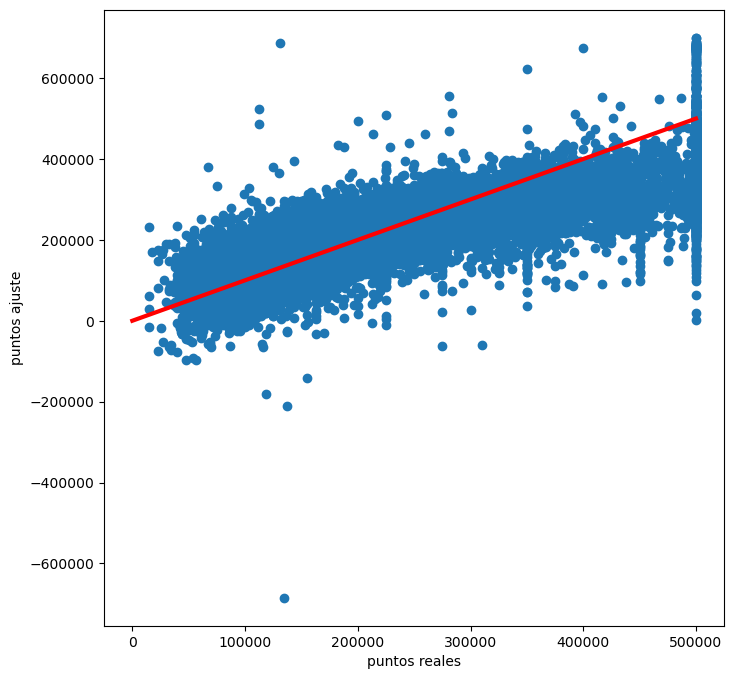

----------------obtener observacion medianas-------------------------------------
[ 0.53891366 -0.6422871   0.02864572 -0.23321042 -0.24283094 -0.22913175
 -0.23681619 -0.17679508]
el valor de y predicho es:  [204449.69888918] dólares
-----------------------------------------------------


In [91]:
#EJERCICIO 1
# cargar librerias-----------------------------------------------
import pandas as pd
import os
import tarfile
import urllib.request
import numpy as np
from pandas.core.common import flatten
from plotnine import *
from array import *
import scipy.stats as stats
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
# definir las rutas y caminos donde se encuentran los datos------
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
# path que se va a crear en nuestro sistema----------------------
HOUSING_PATH = os.path.join("datasets", "housing")
# lugar de descarga del dataset----------------------------------
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# definir una funcion que obtenga los datos y los descargue-----
def fetch_housing_data(housing_url=HOUSING_URL, 
housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

# definir una funcion que cargue el csv en un dataframe----------
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    
housing = load_housing_data()

print(housing.head())

# separar variable respuesta del dataset-------------------------
respuesta = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)

# recordatorio variables numericas-------------------------------
print("Housing inicial: \n",housing.info())
print("-----------------------------------------------------")



# imputar NAs----------------------------------------------------
# Esto rellena los valores faltantes aplicando la mediana.
from sklearn.impute import SimpleImputer
imputador = SimpleImputer(strategy="median")

# imputador.fit(housing) # da error
# se quita la variable categorica--------------------------------
housing_num = housing.drop("ocean_proximity", axis=1)

# Transformar las variables categóricas
#moda_ocean_proximity = housing['ocean_proximity'].mode()[0]
#print("La moda de ocean_proximity es:", moda_ocean_proximity)

#housing_num = pd.get_dummies(housing, columns=['ocean_proximity'], drop_first=True)
print(housing_num.info())




# se calcula la imputacion---------------------------------------
imputador.fit(housing_num)

# los valores de las medianas------------------------------------
print("Imputador: \n", imputador.statistics_)
print("-----------------------------------------------------")

# se aplica la imputacion----------------------------------------
housing_num_i = imputador.transform(housing_num) #array
housing_i = pd.DataFrame(housing_num_i, columns=housing_num.columns, index=housing.index)

# Comprobar df imputado------------------------------------------
print("Housing con imputaciones: \n", housing_i.info())
print("-----------------------------------------------------")


# importar el "estandarizador"-----------------------------------
from sklearn.preprocessing import StandardScaler
# importar la clase pipeline"------------------------------------
from sklearn.pipeline import Pipeline
# definir el pipeline--------------------------------------------
num_pipeline = Pipeline([
        ("imputador", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ])

# aplicar el pipeline--------------------------------------------
# Esto hace fit del imputador y del std_scaler y luego el transform de ambos
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_i_tr = pd.DataFrame(housing_num_tr, columns=housing_num.columns, index=housing.index)
print("-`-`--`-`-`-`--`--`--``--`-`-`-`-`-`-``--``-`--`-`-`")
print(housing_i_tr.describe())



# Modelo de regresión lineal
# importar clase-------------------------------------------------
from sklearn.linear_model import LinearRegression
# ajustar el modelo----------------------------------------------
lm1 = LinearRegression()
lm1.fit(housing_num_tr, respuesta)

# obtener coeficientes del modelo--------------------------------
# intercepto
print("-------------------Intercepto----------------------------------")
print(lm1.intercept_)
print("-------------------Coeficientes----------------------------------")
# coeficientes de regresion
print(lm1.coef_)



print("----------------------OLS model-------------------------------")
# cargar funciones-----------------------------------------------
import statsmodels.api as sm
from scipy import stats

# definir las variables independientes y variable respuesta-----------------
X = housing_num_tr
y = respuesta

# añadir intercepto---------------------------------------------
X2 = sm.add_constant(X)

# ajustar el modelo----------------------------------------------
est = sm.OLS(y, X2)

# ver ajuste-----------------------------------------------------
est2 = est.fit()

print(est2.summary())


print("--------------------pintar reales vs predichos---------------------------------")
# pintar reales vs predichos
fig = plt.figure(figsize=(8, 8))
y_pred = lm1.predict(housing_num_tr)
print(y_pred)
plt.scatter(y, y_pred)
plt.xlabel("puntos reales")
plt.ylabel("puntos ajuste")
plt.plot([0, max(y)], [0, max(y)], color = 'red', linewidth = 3)
plt.show()



print("----------------obtener observacion medianas-------------------------------------")
# obtener observacion medianas
medianas = np.median(housing_num_tr, axis=0)
#medianas = housing_i_tr.median(numeric_only=True)

print(medianas)

# obtener observacion para predecir
x_nueva = np.array(medianas)
x2 = x_nueva.reshape(1, -1)

y_nueva = lm1.predict(x2)
print("el valor de y predicho es: ", y_nueva, "dólares")
print("-----------------------------------------------------")



C:\software\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NEAR BAY    20640 non-null  float64
 1   <1H OCEAN   20640 non-null  float64
 2   INLAND      20640 non-null  float64
 3   NEAR OCEAN  20640 non-null  float64
 4   ISLAND      20640 non-null  float64
dtypes: float64(5)
memory usage: 806.4 KB
None
242709.1352491365
[-52952.95152846 -53767.62485624  13312.88334575 -10320.06092603
  29920.76507621 -44490.47744263  29746.22226671  73636.15586366
 -23472.13460582 -63238.53335023 132593.58521653 -27169.53626692
 -18713.38099356]
219237.00064331226
[-52952.95152846 -53767.62485624  13312.88334575 -10320.06092603
  29920.76507621 -44490.47744263  29746.22226671  73636.15586366
 -39766.3987444  156065.71982235  -3697.40166109   4758.75361226

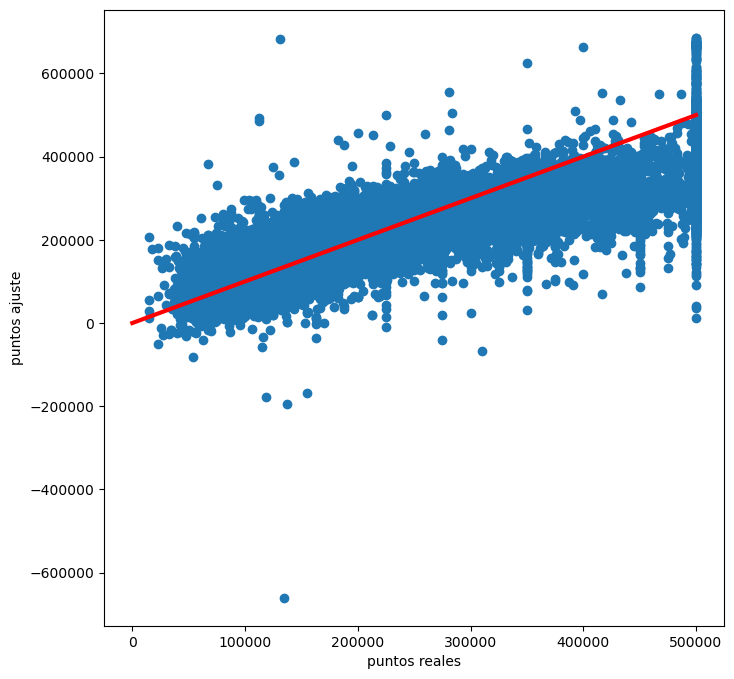

[ 0.53891366 -0.6422871   0.02864572 -0.23321042 -0.24283094 -0.22913175
 -0.23681619 -0.17679508]
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64
el valor de y predicho es:  [210887.88263401] dólares.


In [4]:
#EJERCICIO2
# Transformar variable categorica en variables indicadoras-------
# guardar variable-----------------------------------------------
ocean_cat = housing[["ocean_proximity"]]
# crear categorias para los encabezados--------------------------
header_ocean_cat = housing["ocean_proximity"].unique()
from sklearn.preprocessing import OneHotEncoder
indicar_var = OneHotEncoder(sparse=False)
ocean_indicadora = indicar_var.fit_transform(ocean_cat)
print(ocean_indicadora)
# volver a data frame--------------------------------------------
ocean_df = pd.DataFrame(ocean_indicadora,
columns = header_ocean_cat, index = housing.index)
# Comprobar ocean_df---------------------------------------------
print(ocean_df.info())
# importar clase-------------------------------------------------
from sklearn.compose import ColumnTransformer
# separar dataset en variables numericas y variable categorica---
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
# definir full pipeline------------------------------------------
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)
# importar clase-------------------------------------------------
from sklearn.linear_model import LinearRegression
# ajustar el modelo----------------------------------------------
lm2 = LinearRegression()
lm2.fit(housing_prepared, respuesta)
# obtener coeficientes del modelo--------------------------------
# intercepto
print(lm2.intercept_)
# coeficientes de regresion
print(lm2.coef_)
# importar clase-------------------------------------------------
from sklearn.compose import ColumnTransformer
# separar dataset en variables numericas y variable categorica---
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
# definir full pipeline------------------------------------------
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(drop = "first"), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)
# importar clase-------------------------------------------------
from sklearn.linear_model import LinearRegression
# ajustar el modelo----------------------------------------------
lm2 = LinearRegression()
lm2.fit(housing_prepared, respuesta)
# obtener coeficientes del modelo--------------------------------
# intercepto
print(lm2.intercept_)
# coeficientes de regresion
print(lm2.coef_)
# cargar funciones-----------------------------------------------
import statsmodels.api as sm
from scipy import stats
# definir matriz de disenyo y variable respuesta-----------------
X = housing_prepared
y = respuesta
# anyadir intercepto---------------------------------------------
X2 = sm.add_constant(X)
# ajustar el modelo----------------------------------------------
est = sm.OLS(y, X2)
# ver ajuste-----------------------------------------------------
est2 = est.fit()
print(est2.summary())
# pintar reales vs predichos
fig = plt.figure(figsize=(8, 8))
y_pred = lm2.predict(housing_prepared)

plt.scatter(y, y_pred)
plt.xlabel("puntos reales")
plt.ylabel("puntos ajuste")
plt.plot([0, max(y)], [0, max(y)], color = 'red', linewidth = 3)
plt.show()
# obtener observacion medianas
medianas = np.median(housing_num_tr, axis=0)
print(medianas)
# la moda de
print(housing["ocean_proximity"].value_counts())
# obtener observacion para predecir
array_medianas = np.array(medianas)
x_nueva = np.append(array_medianas, [0, 0, 0, 0])
x2 = x_nueva.reshape(1, -1)
y_nueva = lm2.predict(x2)

print("el valor de y predicho es: ", y_nueva, "dólares.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.8

In [5]:
#EJERCICIO3
# cargar funcion-------------------------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor
# predictores ejercicio 1
housing_i.info()
# crear dataframe para aplicar VIF
ej1_VIF = pd.DataFrame()
ej1_VIF["variable"] = housing_i.columns
# aplicar el metodo
ej1_VIF["VIF"] = [variance_inflation_factor(housing_i.values, i)
for i in range(len(housing_i.columns))]
# resultados
print(ej1_VIF)
# cargar funcion-------------------------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor
# predictores ejercicio 2
housing.info()
housing_t = pd.merge(housing_i, ocean_df, left_index = True
, right_index=True)
# es necesario quitar una de las variables categoricas-----------
housing_t = housing_t.drop("<1H OCEAN", axis=1)
# Comprobar df creado--------------------------------------------
print(housing_t.info())
# crear dataframe para aplicar VIF
ej2_VIF = pd.DataFrame()
ej2_VIF["variable"] = housing_t.columns
# aplicar el metodo
ej2_VIF["VIF"] = [variance_inflation_factor(housing_t.values, i)
for i in range(len(housing_t.columns))]
# resultados
print(ej2_VIF)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
             variable         VIF
0           longitude  614.390295
1            latitude  548.954416
2  housing_median_age    7.281102
3         total_rooms   29.032423
4      total_bedrooms   70.525566
5          population   16.173089
6          households   73.547059
7       median_income    8.003945
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 